# 3D VoCC with merging circles across depth layers 

Similar to the previous notebook 6.2 this notebook introduces the second 3D VoCC implementation with merging circles along the depth axis.


In [1]:
from py_eddy_tracker.dataset.grid import UnRegularGridDataset
from datetime import datetime
import numpy as np
from VoCC import VortexCorrelationClustering
from shapely.geometry import Point

%run ../scripts/experiment_utils.py

MIN_PARTICLES = 40

In [2]:

def get_py_eddy_tracker_labels():
    g = UnRegularGridDataset('../data/ssh_u_v_1d_20111029.nc',
                        'nav_lon', 'nav_lat', centered=True)
    g.high_filter('ssh',w_cut=700,factor=8.0)
    date = datetime(2011,10,29)
    a,c = g.eddy_identification('ssh', 'u', 'v', date = date, step=0.004, shape_error=70)


    # Load the particles dataset

    coordinates = np.load('../data/particles_29102011.npy')
    X,Y,U,V = coordinates[::3].T

    # The magnitude of the movement are two days we normalize them to one.
    U /= 2
    V /= 2
    # Set outliers to zero
    U[U > 1] = 0
    V[V > .5] = 0

    def extract_lagrangian_eddies(eddy_dataset, particles_x, particles_y, particle_threshold):
        counts, _ = np.histogram(eddy_dataset.contains(particles_x, particles_y), bins = np.arange( len(eddy_dataset)+1))
        mask_indices = np.argwhere(counts >= particle_threshold).squeeze()

        mask = np.zeros(len(eddy_dataset.obs), dtype=bool)
        mask[mask_indices] = True

        return eddy_dataset.extract_with_mask(mask)


    particle_eddy_a = extract_lagrangian_eddies(a, X, Y, MIN_PARTICLES).contains(coordinates[:,0],coordinates[:, 1])
    particle_eddy_c = extract_lagrangian_eddies(c, X, Y, MIN_PARTICLES).contains(coordinates[:,0],coordinates[:, 1])

    particle_eddy_c[particle_eddy_c >= 0] += particle_eddy_a.max() +1

    particle_eddy_labels = np.max(np.vstack((particle_eddy_a, particle_eddy_c)), axis = 0)
    return particle_eddy_labels, a, c

particle_eddy_labels, a, c = get_py_eddy_tracker_labels()

In [4]:
coordinates = np.load('../data/particles_29102011_depth.npy')
X,Y,U,V,D = coordinates.T

# The magnitude of the movement are two days we normalize them to one.
U /= 2
V /= 2
# Set outliers to zero
U[U > 1] = 0
V[V > .5] = 0

In [5]:
vocc = VortexCorrelationClustering(
    radii=np.arange(4,24,4),
    cell_size= .07, 
    sectors = 15, 
    circle_coverage_rate = .75, 
    qth_threshold = .99, 
    min_points = .01,
    depth_boundaries=-depth_layers[::6]
)
default_labels = vocc.fit(coordinates).labels_

<GeoAxes: >

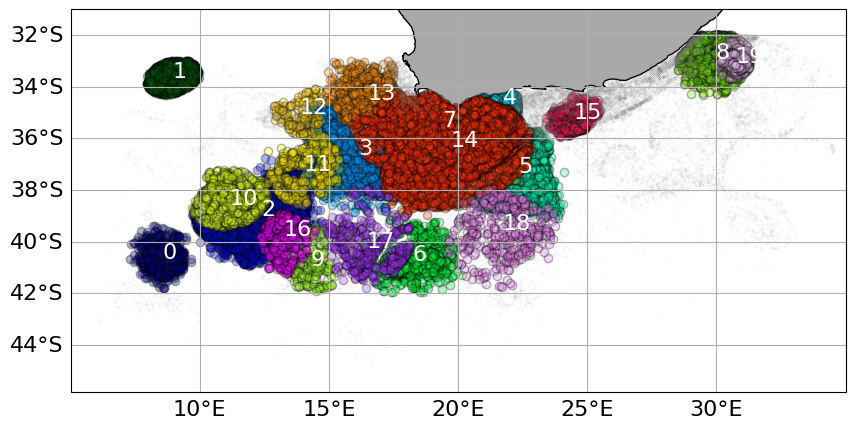

In [6]:
create_real_world_image(coordinates, default_labels, '63_vocc_clustering_6th', True)

In [7]:
from sklearn.metrics import adjusted_rand_score
label_mask = particle_eddy_labels > -1
print(f'A-Rand score for 3D VoCC with merging six depth layers into one clustering layer: {adjusted_rand_score(particle_eddy_labels[label_mask], default_labels[label_mask]):.4f}')

A-Rand score for 3D VoCC with merging six depth layers into one clustering layer: 0.8368


In [8]:
rand_score = []
rand_score_noise = []

for i in range(2,50, 2):
    vocc = VortexCorrelationClustering(
        radii=np.arange(4,24,4),
        cell_size= .07, 
        sectors = 15, 
        circle_coverage_rate = .75, 
        qth_threshold = .99, 
        min_points = .01,
        depth_boundaries=-depth_layers[::i]
    )
    layered_labels = vocc.fit(coordinates).labels_

    rand_score.append( adjusted_rand_score(particle_eddy_labels[label_mask], layered_labels[label_mask]))
    rand_score_noise.append( adjusted_rand_score(particle_eddy_labels, layered_labels))

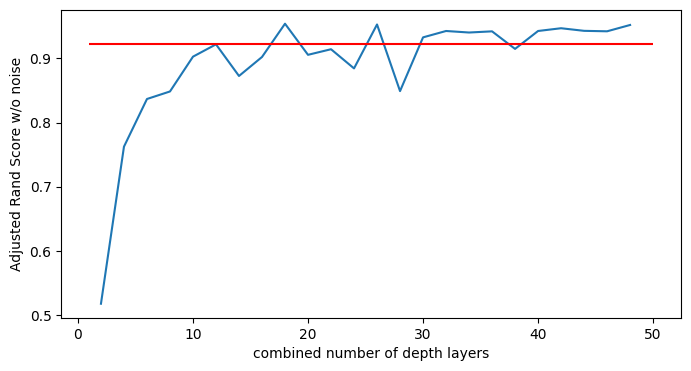

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(2,50, 2), rand_score)
#plt.plot(np.arange(2,50, 2), rand_score_noise)
ax.hlines(0.9222, 1, 50, label='Default VoCC', color='red')

ax.set_xlabel('combined number of depth layers')
ax.set_ylabel('Adjusted Rand Score w/o noise')

plt.savefig('../fig/63_depth_arand_score.png')

14.220999220938015
7.935049267752338


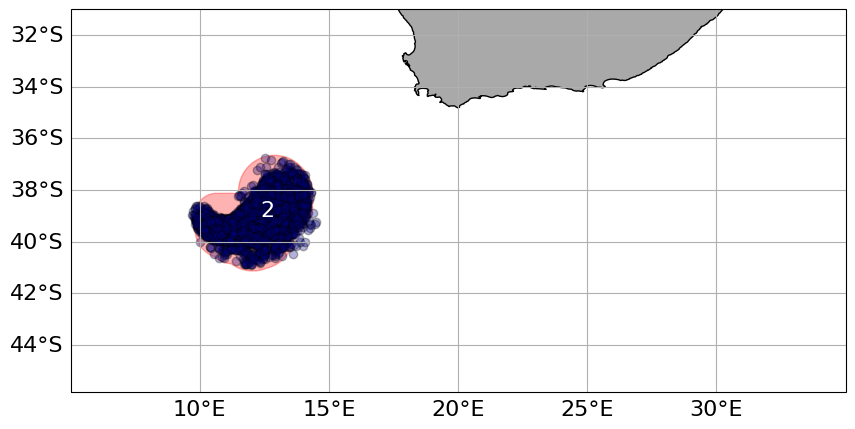

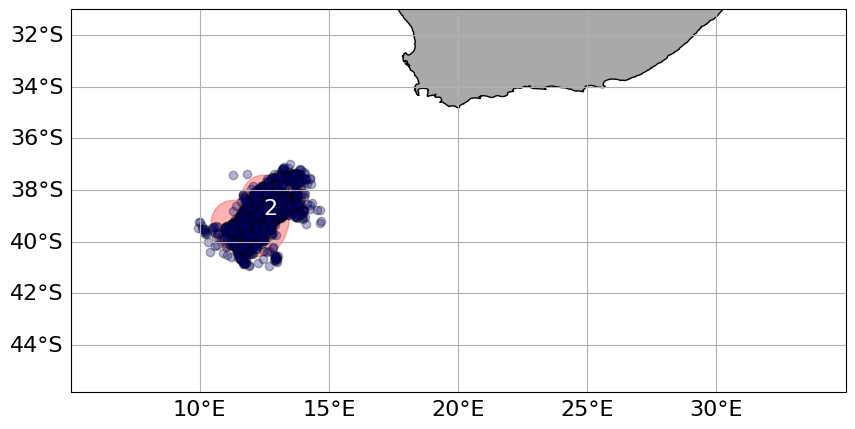

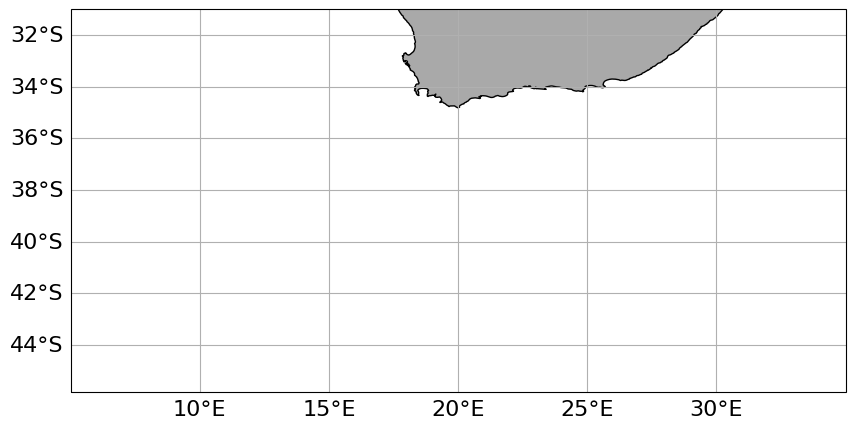

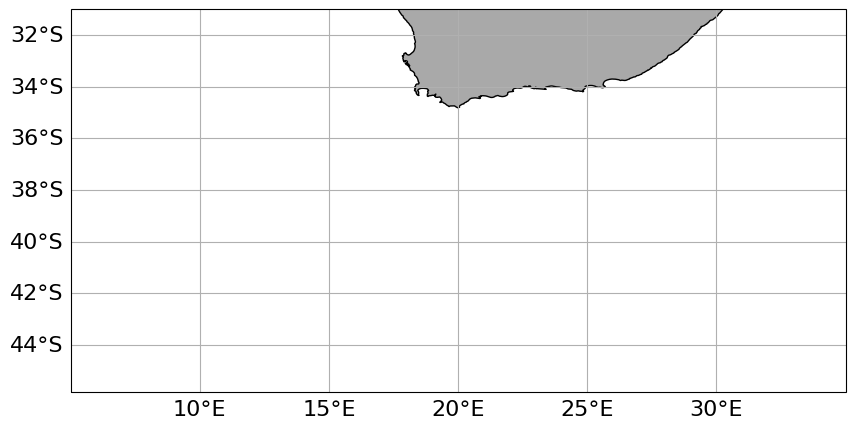

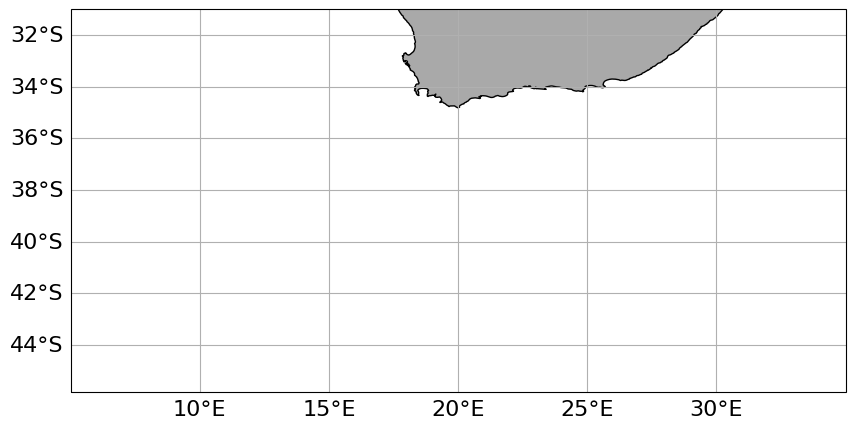

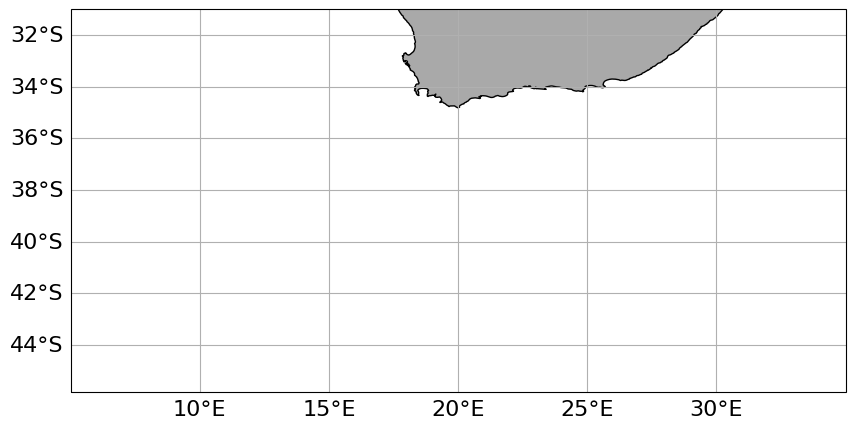

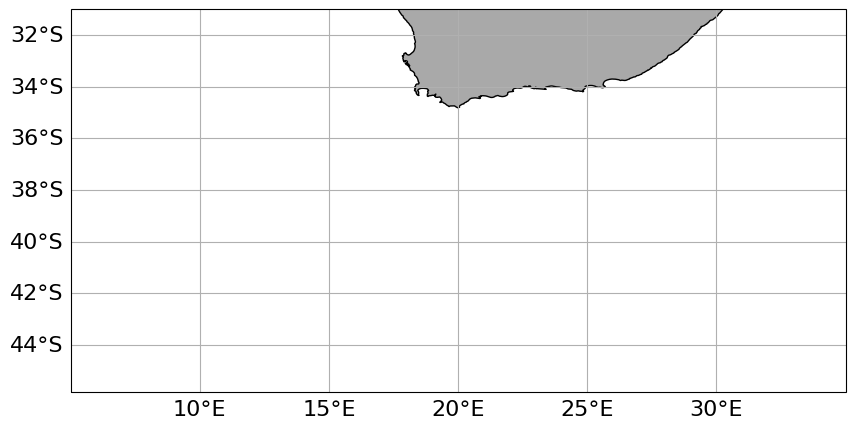

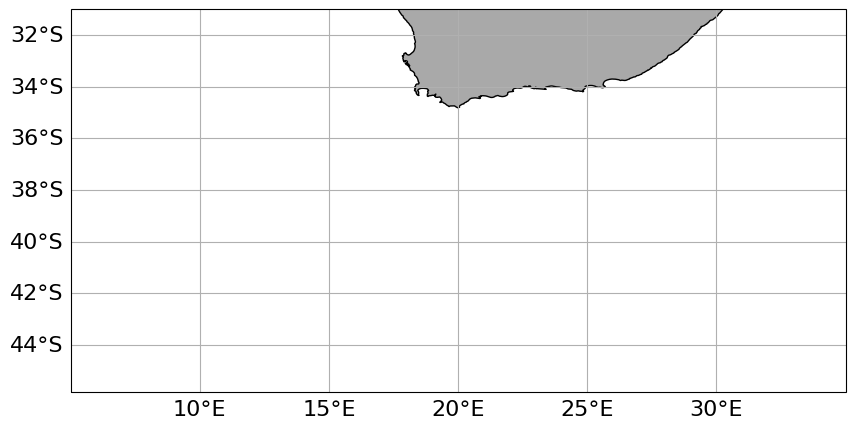

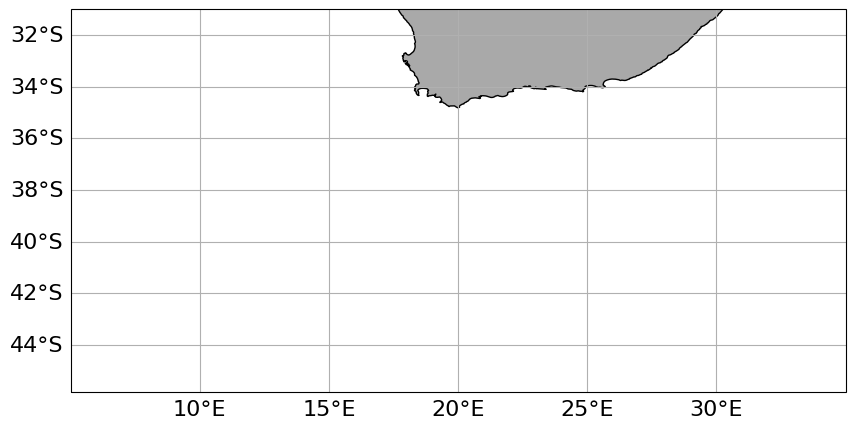

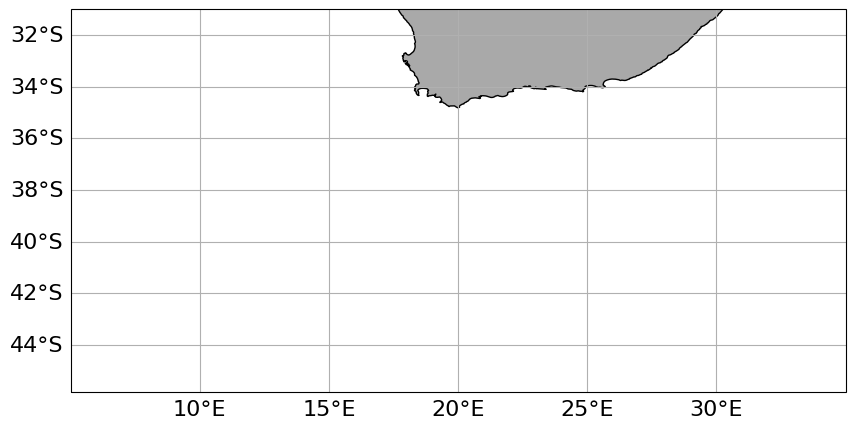

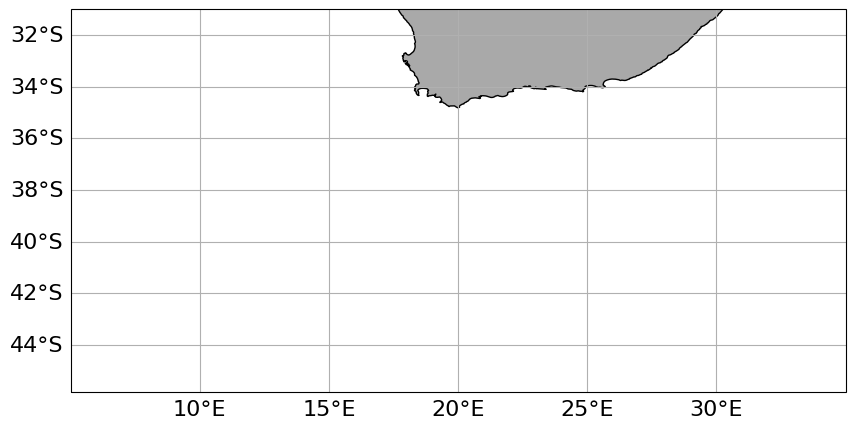

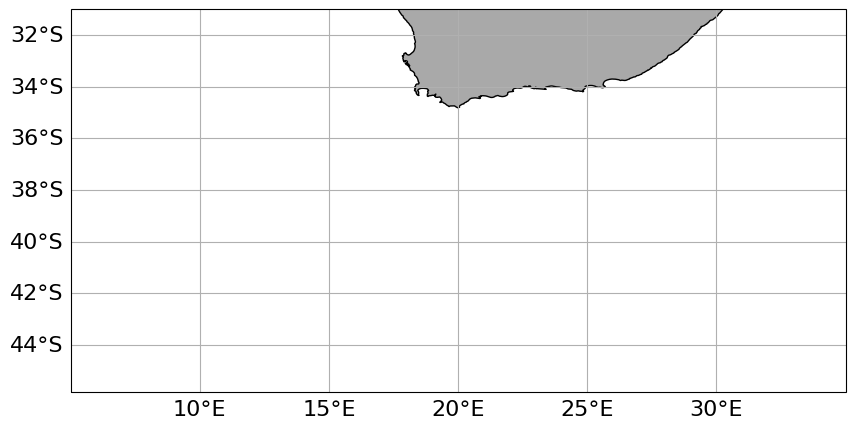

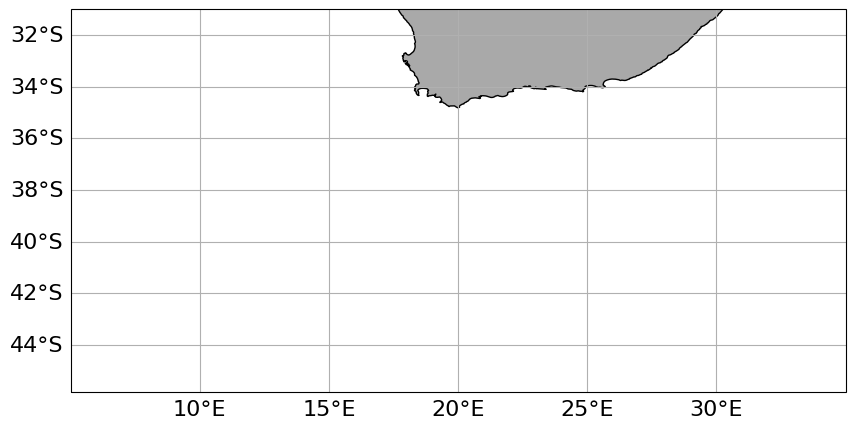

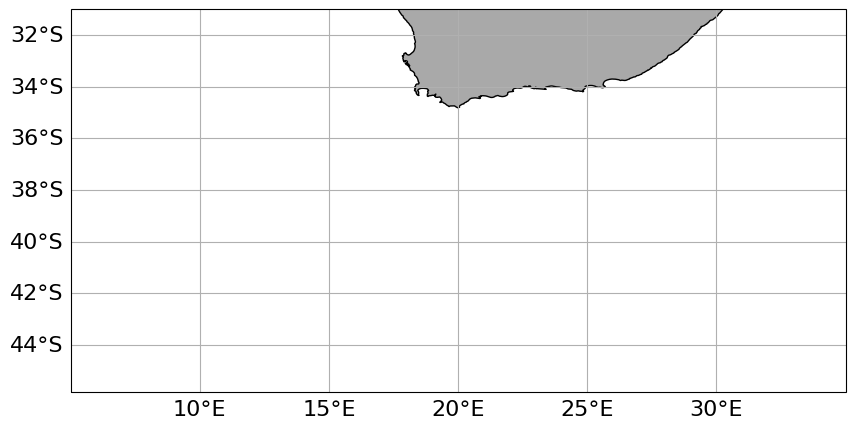

In [11]:


# Looking in detial at all depth levels for a single eddy. Showing the labeled particles and the contour of all circles in the VoCC result.
vortex_id = 2
for i in range(1, 15):
    mask = (default_labels == vortex_id) & (vocc.D_binned == i)


    ax = create_real_world_image(coordinates[mask], default_labels[mask], 'VoCC-result-real-world', True)

    vortex = vocc.vortices_[vortex_id]

    depth_mask = vortex.pixels[:, 3] == i

    out_side_polygon = None
    for (circle_x, circle_y), radius in zip(vortex.get_circle_positions()[depth_mask], vortex.get_circle_radii()[depth_mask]):     
            
        circle_x = circle_x * vocc.cell_size + vocc.min_positions[0]
        circle_y = circle_y * vocc.cell_size + vocc.min_positions[1]
        radius = radius * vocc.cell_size
        # ax.add_patch(Circle((circle_x, circle_y), radius, fill=False, color='red'))

        abc = Point(circle_x, circle_y).buffer(radius)
        
        if out_side_polygon is None:
            out_side_polygon = abc
        else:
            out_side_polygon = out_side_polygon.union(abc)


    if out_side_polygon is not None:

        ax.add_geometries([out_side_polygon], crs=PlateCarree(), facecolor='red', edgecolor='red', alpha=.3)

        print(out_side_polygon.area)

    # Check if the circle is copletetly covered by any other circle
    
